# Анализ объявлений с avto.ru для Ford Focus II и III

Тут мы пробуем спиздить данные с avto.ru и как-то их проанализировать.
Нас интересуют данные по машинам Ford Focus, II поколение (+рестайлинг) и III поколение, кузовы седан, хэтчбэк, лифтбэк, по всем регионам.

In [27]:
from datetime import datetime
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.dates import HourLocator, DayLocator, MonthLocator, YearLocator, DateFormatter
from matplotlib.pylab import rcParams
import numpy as np
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.figure_factory as ff

import plotly.graph_objs as go
import seaborn as sb
import folium
import json
import warnings                    # убираем ошибки из output 
warnings.filterwarnings('ignore')

import ipywidgets as widgets

init_notebook_mode(connected=True)
rcParams['figure.figsize'] = 15,6
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [28]:
name = ''


task_name = widgets.Text(
    placeholder='Введи имя папки с json-ами',
    description='Task name:'
)
def on_input(t): # Описываем обработчик события
    
    global name
    
    name = task_name.value

task_name.observe(on_input)
task_name

Text(value='', description='Task name:', placeholder='Введи имя папки с json-ами')

In [29]:
name = 'ford_focus_all'
path = f'/home/ivan/WORK/PYTHON/studying/scrapy_spiders/avtoru/responses/' + name
number_of_files = len(os.listdir(path))
print(f'Number of response files - {number_of_files}')

Number of response files - 99


In [30]:
offers = []
for i in range(1, number_of_files + 1):
    with open(path + f'/response_page_{i}.json') as f:
        d = json.load(f)['offers']
        offers.extend(d)
df = pd.DataFrame(offers)
df.set_index(pd.Index(range(df.shape[0])))
df['owners_number'] = df.documents.apply(lambda x: x['owners_number'])
df['pts_original'] = df.documents.apply(lambda x: x['pts'])
df['custom_cleared'] = df.documents.apply(lambda x: x['custom_cleared'])
df['year'] = df.documents.apply(lambda x: x['year'])
# df['tax_by_year'] = df.owner_expenses.apply(lambda x: json.load(x)['transport_tax'])
# df['tax_by_year'] = df.owner_expenses.apply(lambda x: x['transport_tax']['tax_by_year'])
df['horse_power'] = df.vehicle_info.apply(lambda x: x['tech_param']['power'])
df['seller_coords'] = df.seller.apply(lambda x: (x['location']['coord']['latitude'], 
                                                 x['location']['coord']['longitude']))
df.drop(df[df.price_info == {}].index, axis=0, inplace=True)
df['price'] = df.price_info.apply(lambda x: x['price'])
df['state_mileage'] = df.state.apply(lambda x: x['mileage'])
df['state_not_beaten'] = df.state.apply(lambda x: x['state_not_beaten'])
useless_columns = ['documents', 'is_favorite', 'old_category_id', 'category', 'delivery_info', 'tags', 
                   'counters', 'grouping_info', 'hash', 'id', 'recall_info', 'saleId', 'sub_category',
                   'multiposting', 'discount_price', 'dealer_credit_config', 'soldMinutes',
                   'discount_options', 'section', 'services', 'shark_info', 'additional_info', 'price_info',
                   'owner_expenses', 'price_history', 'salon', 'seller', 'badges', 'service_prices']
for column in useless_columns:
    try:
        df.drop(column, axis=1, inplace=True)
    except KeyError:
        continue
df.head()

,availability,color_hex,description,seller_type,status,state,vehicle_info,lk_summary,owners_number,pts_original,custom_cleared,year,horse_power,seller_coords,price,state_mileage,state_not_beaten
0,IN_STOCK,040001,Автомобиль прошел проверку 100%-ной юридическо...,COMMERCIAL,ACTIVE,"{'mileage': 171233, 'state_not_beaten': True, ...","{'configuration': {'id': '7306610', 'body_type...","1.6 AMT (125 л.с.), хэтчбек 5 дв., передний, б...",2,ORIGINAL,True,2011,125,"(54.64756, 39.654179)",470000,171233,True
1,IN_STOCK,CACECB,Форд фокус 3. Двухлитровый мотор 150лс. 2 влад...,PRIVATE,ACTIVE,"{'mileage': 103000, 'state_not_beaten': True, ...","{'configuration': {'id': '7306625', 'body_type...","2.0 AMT (150 л.с.), седан, передний, бензин",2,ORIGINAL,True,2013,150,"(59.93895, 30.315636)",505000,103000,True
2,IN_STOCK,040001,Продаётся Форд Фокус 2 до рестайлинг.\n-двигат...,PRIVATE,ACTIVE,"{'damages': [{'car_part': 'FRONT_BUMPER', 'typ...","{'configuration': {'id': '3480338', 'body_type...","2.0 MT (145 л.с.), хэтчбек 3 дв., передний, бе...",3,ORIGINAL,True,2005,145,"(56.342316, 30.521969)",260000,214265,True
3,IN_STOCK,97948F,"Продается Ford Focus 2010 года, очень красивый...",PRIVATE,ACTIVE,"{'mileage': 108000, 'state_not_beaten': True, ...","{'configuration': {'id': '2306688', 'body_type...","1.6 AT (100 л.с.), хэтчбек 5 дв., передний, бе...",2,ORIGINAL,True,2010,100,"(55.753216, 37.622505)",449000,108000,True
4,IN_STOCK,EE1D19,"Машина в отличном состоянии! Салон эко кожа, 9...",PRIVATE,ACTIVE,"{'mileage': 96000, 'state_not_beaten': True, '...","{'configuration': {'id': '7306610', 'body_type...","2.0 AMT (150 л.с.), хэтчбек 5 дв., передний, б...",3,ORIGINAL,True,2012,150,"(56.838013, 60.597466)",535000,96000,True


In [31]:
df.shape

(3663, 17)

In [ ]:
# fig = ff.create_distplot([df.price], group_labels=['ford'], show_rug=False)
# fig.update_layout(title_text='Цена')
# fig.show()

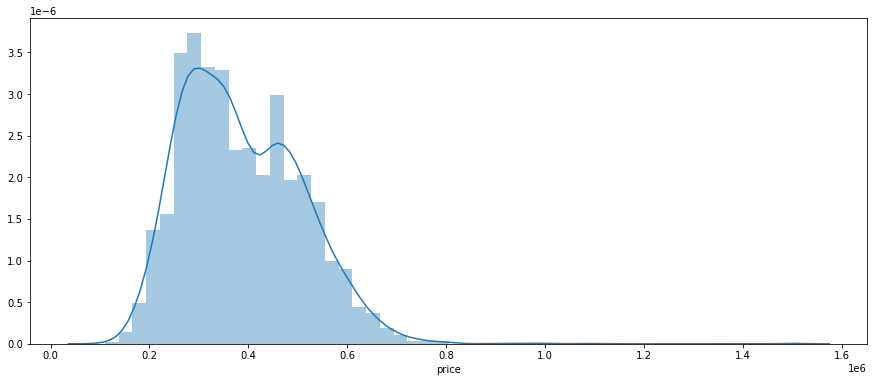

In [32]:
sb.distplot(df.price);

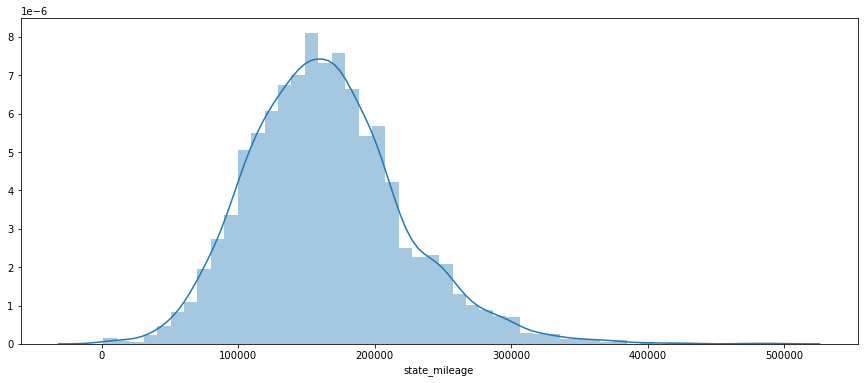

In [33]:
sb.distplot(df.state_mileage);

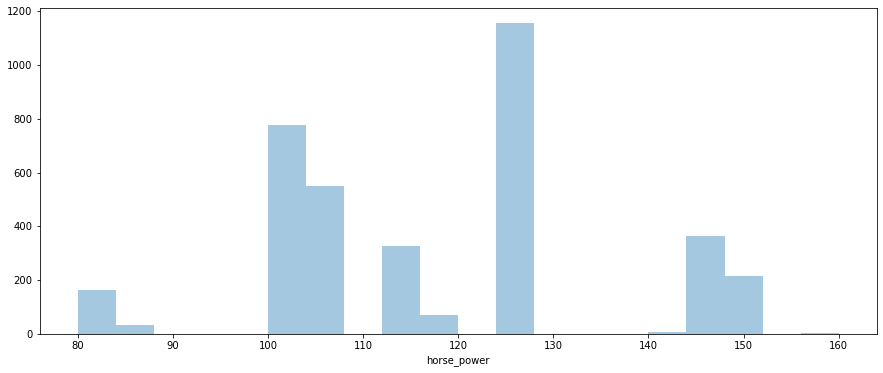

In [34]:
sb.distplot(df.horse_power, kde=False, bins=20);

In [35]:
m = folium.Map(location=[70.5236, 105.6750],
               zoom_start=3)

for i in df.index:
    folium.Circle( (df.seller_coords[i][0], df.seller_coords[i][1]), 
                  radius=70,
                  tooltip=df.price[i],
                  opacity=1,
                  fill=True,
                  
                  color=f'#{df.color_hex[i]}').add_to(m)
m